## Load Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# distributions
import scipy.integrate as integrate
from scipy.integrate import quad, quad_vec
from scipy.stats import invgamma
from scipy.stats import levy
from scipy.special import gamma, erfinv

import time
from datetime import datetime, timedelta

import sys
import importlib # ref: https://askubuntu.com/questions/144698/find-a-file-by-name-using-command-line
import seaborn as sns

import os

In [2]:
sys.path.append('../tools')
import tools

In [3]:
importlib.reload(tools)

<module 'tools' from '../tools/tools.py'>

## Download Data

In [4]:
# download and store data in a file
df = pd.read_csv('data/apple_cleaned.csv')


In [45]:
# decide whether you use sample or not
sample = True

if sample:
    data = df[df['date']< '2017-01-30']
    
else:
    data = df.copy()

In [46]:
data

,date,ts,date_ts,delta_ts,bin
0,2017-01-03,09:30:00.001271,2017-01-03 09:30:00.001271,NaN,1
1,2017-01-03,09:30:00.046605,2017-01-03 09:30:00.046605,0.045334,1
2,2017-01-03,09:30:00.090184,2017-01-03 09:30:00.090184,0.043579,1
3,2017-01-03,09:30:00.090207,2017-01-03 09:30:00.090207,0.000023,1
4,2017-01-03,09:30:00.090214,2017-01-03 09:30:00.090214,0.000007,1
...,...,...,...,...,...
2337914,2017-01-27,15:59:59.961296,2017-01-27 15:59:59.961296,0.000006,13
2337915,2017-01-27,15:59:59.982575,2017-01-27 15:59:59.982575,0.021279,13
2337916,2017-01-27,15:59:59.982617,2017-01-27 15:59:59.982617,0.000042,13
2337917,2017-01-27,15:59:59.983048,2017-01-27 15:59:59.983048,0.000431,13


## Fitting Distribution

### Fitting Inverse Gamma Distribution

#### Not fixing Location at 0

In [26]:
### Get a daily estimate of the parameter and then take and average
a_daily_float = []
b_loc_float = []
b_daily_float = []

days = data['date'].unique()

for day in days:
    
    # estimate levy parameters
    a, loc, b = invgamma.fit(data.loc[data['date']==day,]['delta_ts'].dropna(), 
                            loc = 0)
    
    # append it to the list
    a_daily_float.append(a)
    b_loc_float.append(loc)
    b_daily_float.append(b)

/Users/kotakikuchi/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [27]:
## Get a 30 minute block estimate of the parameter and then take an average
a_30_minutes_float = []
b_30_minutes_float = []

blocks = data['bin'].unique()

# for each day
for day in days:
    
    # for each block
    for block in blocks:
        
        # estimate levy parameters
        a, loc, b = invgamma.fit(data.loc[(data['date']==day) & (data['bin'] == block),]['delta_ts'].dropna(),
                                loc = 0)

        # append it to the list
        a_30_minutes_float.append(a)
        b_30_minutes_float.append(b)

In [28]:
## get an estimate using the entier data
a_entire, loc_entire, b_entire = invgamma.fit(data.loc[data['date']==day,]['delta_ts'].dropna(),
                                             loc = 0)

In [41]:
estimates_daily = [a_daily_float, b_daily_float]
estimates_30_mins = [a_30_minutes_float, b_30_minutes_float]
estimate_entire = [a_entire, b_entire]


summaries = pd.DataFrame(
[np.mean(estimates_daily, axis = 1),
 np.median(estimates_daily, axis = 1),
 
 np.mean(estimates_30_mins, axis = 1),
 np.median(estimates_30_mins, axis = 1),
 
 estimate_entire
],
    columns = [' $\\alpha$', '$\\beta$'],
    index = ['Daily Block (Mean)', 'Daily Block (Median)',
             '30 Minutes Block (Mean)', '30 Minutes Block (Median)',
             'Entire Data']
)

In [44]:
summaries

,$\alpha$,$\beta$
Daily Block (Mean),1.095044,0.444627
Daily Block (Median),0.169599,0.000002
30 Minutes Block (Mean),1.805156,10.377699
30 Minutes Block (Median),0.170694,0.000002
Entire Data,0.165865,0.000002


In [43]:
print(summaries.to_latex( caption = 'Estimated shape and scale parameter for the Inverse Gamma distribution of the first-hitting times in seconds for Apple in 2017',
                        float_format="%.2f",
                        formatters = {'$\alpha$': "{:.2E}".format,
                                      '$\beta$': "{:.2E}".format
                                     },
                        position = 'H',
                         escape=False))

\begin{table}[H]
\centering
\caption{Estimated shape and scale parameter for the Inverse Gamma distribution of the first-hitting times in seconds for Apple in 2017}
\begin{tabular}{lrr}
\toprule
{} &   $\alpha$ &  $\beta$ \\
\midrule
Daily Block (Mean)        &       1.10 &     0.44 \\
Daily Block (Median)      &       0.17 &     0.00 \\
30 Minutes Block (Mean)   &       1.81 &    10.38 \\
30 Minutes Block (Median) &       0.17 &     0.00 \\
Entire Data               &       0.17 &     0.00 \\
\bottomrule
\end{tabular}
\end{table}



<ipython-input-43-af1c335a76f9>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summaries.to_latex( caption = 'Estimated shape and scale parameter for the Inverse Gamma distribution of the first-hitting times in seconds for Apple in 2017',


### Plots

#### $\alpha$

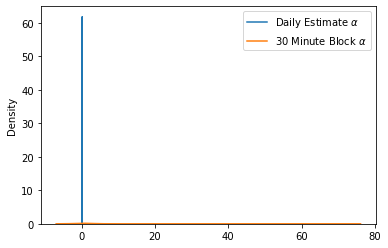

In [17]:
### plotting the scale and shape parameters
sns.kdeplot(a_daily_float, label = r"Daily Estimate $\alpha$")
sns.kdeplot(a_30_minutes_float, label = r"30 Minute Block $\alpha$")


#plt.title(r'Density Plot of $\alpha$ (Location Parameter = 0)')
plt.legend()


plt.savefig('figures/parameters/a_density', facecolor='w')
plt.show()
plt.close()

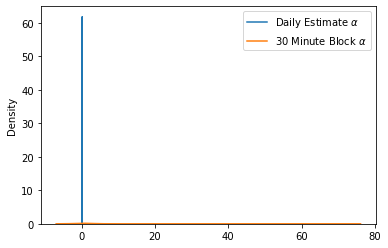

In [18]:
sns.kdeplot(a_daily_float, label = r"Daily Estimate $\alpha$")
sns.kdeplot(a_30_minutes_float, label = r"30 Minute Block $\alpha$")

#plt.title(r'Density Plot of $\alpha$  (Floating Location Parameter)')
plt.legend()

plt.savefig('figures/parameters/a_density_flaot', facecolor='w')
plt.show()
plt.close()

#### $\beta$

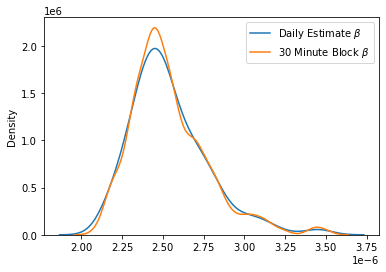

In [77]:
### plotting the scale and shape parameters
sns.kdeplot(b_daily, label = r"Daily Estimate $\beta$")
sns.kdeplot(b_30_minutes, label = r"30 Minute Block $\beta$")


#plt.title(r'Density Plot of $\beta$ (Location Parameter = 0)')
plt.legend()

plt.savefig('figures/parameters/b_density', facecolor='w')
plt.show()
plt.close()

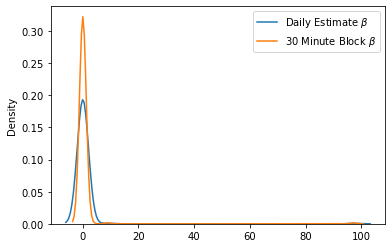

In [78]:
### plotting the scale and shape parameters
sns.kdeplot(b_daily_float, label = r"Daily Estimate $\beta$")
sns.kdeplot(b_30_minutes_float, label = r"30 Minute Block $\beta$")


#plt.title(r'Density Plot of $\beta$ (Floating Location Parameter)')
plt.legend()

plt.savefig('figures/parameters/b_density_float', facecolor='w')
plt.show()
plt.close()